# 🚗💥 Nexar Collision Prediction - Analyse Exploratoire des Données (EDA)

**Auteur** : Jerome  
**Date** : Octobre 2025  
**Projet** : Mémoire de Master 2 - Deep Learning pour la Prédiction de Collisions

---

## 📋 Objectifs de cette Analyse

1. **Comprendre la structure du dataset** (nombre de vidéos, annotations, distribution)
2. **Analyser les caractéristiques des vidéos** (durée, résolution, FPS)
3. **Visualiser des exemples** (collisions, near-miss, conduite normale)
4. **Identifier les patterns temporels** (time-to-accident, alert timing)
5. **Détecter les challenges** (déséquilibre, variabilité, difficulté)
6. **Générer des insights** pour guider la modélisation

---

## 📦 1. Import des Bibliothèques

In [1]:
# Standard libraries
import os
import sys
import warnings
from pathlib import Path
import random

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Video, HTML, display

# Video processing
import cv2

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("✅ Bibliothèques importées avec succès!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🎨 Matplotlib version: {plt.matplotlib.__version__}")
print(f"📹 OpenCV version: {cv2.__version__}")

✅ Bibliothèques importées avec succès!
📊 Pandas version: 2.2.3
🎨 Matplotlib version: 3.9.2
📹 OpenCV version: 4.12.0


## 🗂️ 2. Configuration des Chemins

In [2]:
# Chemins vers les données
DATA_DIR = Path('/Users/jerome/Documents/University/Master2/Semestre1_Projet/Memoire/Nexar-Dashcam-Crash-Prediction-Challenge/Data')

# Fichiers CSV
TRAIN_CSV = DATA_DIR / 'train.csv'
TEST_CSV = DATA_DIR / 'test.csv'
SAMPLE_SUBMISSION = DATA_DIR / 'sample_submission.csv'

# Dossiers vidéos
TRAIN_VIDEO_DIR = DATA_DIR / 'train'
TEST_VIDEO_DIR = DATA_DIR / 'test'

# Vérification de l'existence des fichiers
print("🔍 Vérification des fichiers...\n")
files_to_check = [
    (TRAIN_CSV, "train.csv"),
    (TEST_CSV, "test.csv"),
    (SAMPLE_SUBMISSION, "sample_submission.csv"),
    (TRAIN_VIDEO_DIR, "train/ (dossier vidéos)"),
    (TEST_VIDEO_DIR, "test/ (dossier vidéos)")
]

all_exist = True
for file_path, name in files_to_check:
    if file_path.exists():
        print(f"✅ {name}: Trouvé")
    else:
        print(f"❌ {name}: NON TROUVÉ")
        all_exist = False

if all_exist:
    print("\n✅ Tous les fichiers sont présents!")
else:
    print("\n⚠️ Certains fichiers sont manquants. Vérifiez les chemins.")

🔍 Vérification des fichiers...

✅ train.csv: Trouvé
✅ test.csv: Trouvé
✅ sample_submission.csv: Trouvé
✅ train/ (dossier vidéos): Trouvé
✅ test/ (dossier vidéos): Trouvé

✅ Tous les fichiers sont présents!


## 📊 3. Chargement et Exploration des Données CSV

### 3.1 Training Set

In [18]:
# Charger le fichier train.csv avec id comme string
train_df = pd.read_csv(TRAIN_CSV, dtype={'id': str})

print("📋 TRAINING SET - Aperçu des données\n")
print(f"Nombre total de vidéos: {len(train_df)}")
print(f"Nombre de colonnes: {len(train_df.columns)}")
print(f"\nColonnes: {list(train_df.columns)}")
print("\n" + "="*80)
print("\n📊 Premières lignes:")
display(train_df.head(10))

print("\n" + "="*80)
print("\n📈 Informations sur le dataset:")
train_df.info()

# 🔍 Vérifier le format des IDs
print("\n" + "="*80)
print("\n🔍 Format des IDs:")
print(f"Type: {train_df['id'].dtype}")
print(f"Exemples: {train_df['id'].head(5).tolist()}")

# 🔍 Vérifier les noms de fichiers vidéo
print("\n📁 Noms de fichiers vidéo (5 premiers):")
video_files = sorted(list(TRAIN_VIDEO_DIR.glob('*.mp4')))[:5]
for vf in video_files:
    print(f"  {vf.name}")

📋 TRAINING SET - Aperçu des données

Nombre total de vidéos: 1500
Nombre de colonnes: 4

Colonnes: ['id', 'time_of_event', 'time_of_alert', 'target']


📊 Premières lignes:


,id,time_of_event,time_of_alert,target
0,01924,NaN,NaN,0
1,00822,19.500,18.633,1
2,01429,NaN,NaN,0
3,00208,19.800,19.233,1
4,01904,NaN,NaN,0
5,00072,20.101,20.068,1
6,01486,NaN,NaN,0
7,01171,NaN,NaN,0
8,00128,19.267,18.333,1
9,01518,NaN,NaN,0




📈 Informations sur le dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1500 non-null   object 
 1   time_of_event  750 non-null    float64
 2   time_of_alert  750 non-null    float64
 3   target         1500 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 47.0+ KB


🔍 Format des IDs:
Type: object
Exemples: ['01924', '00822', '01429', '00208', '01904']

📁 Noms de fichiers vidéo (5 premiers):
  00000.mp4
  00003.mp4
  00004.mp4
  00005.mp4
  00006.mp4


In [19]:
# Statistiques descriptives
print("\n📊 Statistiques Descriptives:\n")
display(train_df.describe())

# Valeurs manquantes
print("\n🔍 Valeurs Manquantes:\n")
missing_values = train_df.isnull().sum()
missing_df = pd.DataFrame({
    'Colonne': missing_values.index,
    'Valeurs Manquantes': missing_values.values,
    'Pourcentage': (missing_values.values / len(train_df) * 100).round(2)
})
display(missing_df)


📊 Statistiques Descriptives:



,time_of_event,time_of_alert,target
count,750.000000,750.000000,1500.000000
mean,19.101628,17.501271,0.500000
std,3.565120,3.658975,0.500167
min,3.032000,1.966000,0.000000
25%,19.133000,17.290000,0.000000
50%,19.802000,18.259000,0.500000
75%,20.333000,18.977500,1.000000
max,56.800000,55.467000,1.000000



🔍 Valeurs Manquantes:



,Colonne,Valeurs Manquantes,Pourcentage
0,id,0,0.0
1,time_of_event,750,50.0
2,time_of_alert,750,50.0
3,target,0,0.0


### 3.2 Distribution des Classes (Target)

🎯 DISTRIBUTION DES CLASSES

Classe 0 (Conduite normale): 750 vidéos (50.0%)
Classe 1 (Collision/Near-miss): 750 vidéos (50.0%)

Ratio Positif/Négatif: 1.00


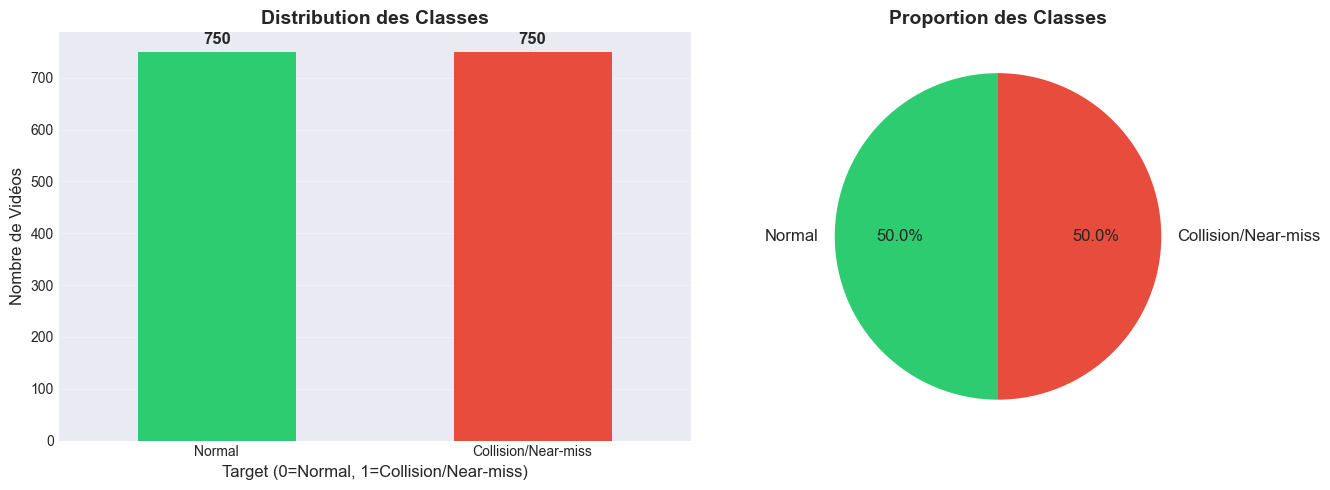


✅ Dataset ÉQUILIBRÉ (50/50) - Excellent pour l'entraînement!


In [20]:
# Distribution des classes
target_counts = train_df['target'].value_counts().sort_index()

print("🎯 DISTRIBUTION DES CLASSES\n")
print(f"Classe 0 (Conduite normale): {target_counts[0]} vidéos ({target_counts[0]/len(train_df)*100:.1f}%)")
print(f"Classe 1 (Collision/Near-miss): {target_counts[1]} vidéos ({target_counts[1]/len(train_df)*100:.1f}%)")
print(f"\nRatio Positif/Négatif: {target_counts[1]/target_counts[0]:.2f}")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
target_counts.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Distribution des Classes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Target (0=Normal, 1=Collision/Near-miss)', fontsize=12)
axes[0].set_ylabel('Nombre de Vidéos', fontsize=12)
axes[0].set_xticklabels(['Normal', 'Collision/Near-miss'], rotation=0)
axes[0].grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(target_counts):
    axes[0].text(i, v + 10, str(v), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Pie chart
colors = ['#2ecc71', '#e74c3c']
axes[1].pie(target_counts, labels=['Normal', 'Collision/Near-miss'], autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Proportion des Classes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Dataset ÉQUILIBRÉ (50/50) - Excellent pour l'entraînement!")

### 3.3 Analyse Temporelle (Time-to-Accident)

⏱️ ANALYSE TEMPORELLE (Time-to-Accident)

Nombre d'échantillons positifs: 750

Statistiques du Time-to-Accident:
  • Moyenne: 1.60 secondes
  • Médiane: 1.43 secondes
  • Min: 0.03 secondes
  • Max: 4.47 secondes
  • Écart-type: 0.87 secondes


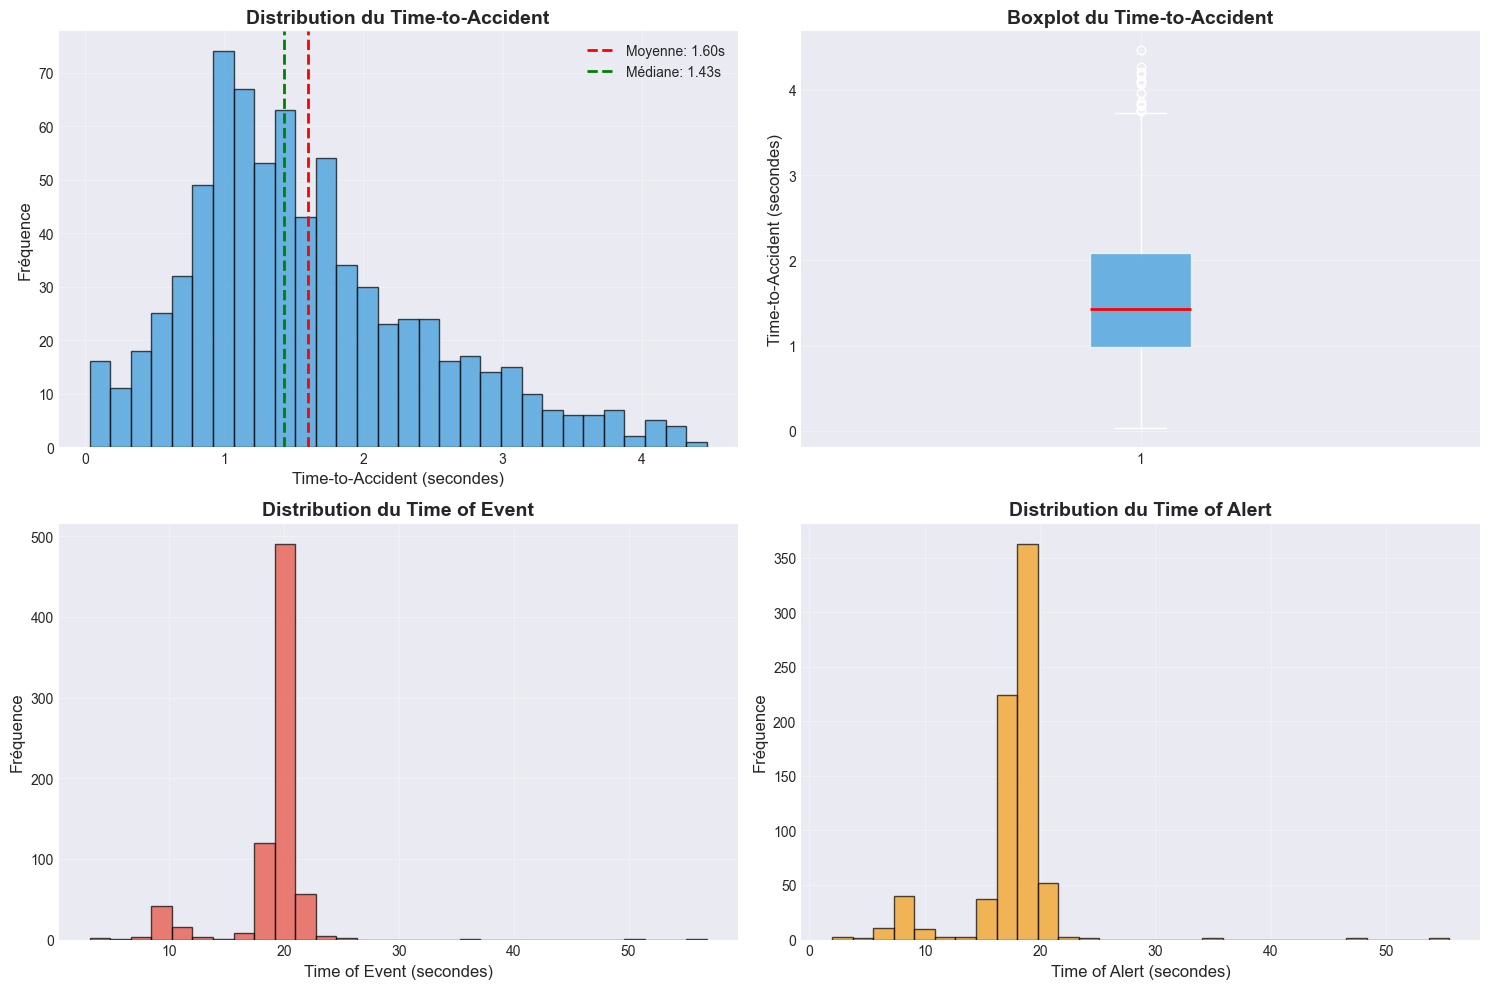

In [21]:
# Calculer le time-to-accident (TTA)
positive_samples = train_df[train_df['target'] == 1].copy()
positive_samples['time_to_accident'] = positive_samples['time_of_event'] - positive_samples['time_of_alert']

print("⏱️ ANALYSE TEMPORELLE (Time-to-Accident)\n")
print(f"Nombre d'échantillons positifs: {len(positive_samples)}")
print(f"\nStatistiques du Time-to-Accident:")
print(f"  • Moyenne: {positive_samples['time_to_accident'].mean():.2f} secondes")
print(f"  • Médiane: {positive_samples['time_to_accident'].median():.2f} secondes")
print(f"  • Min: {positive_samples['time_to_accident'].min():.2f} secondes")
print(f"  • Max: {positive_samples['time_to_accident'].max():.2f} secondes")
print(f"  • Écart-type: {positive_samples['time_to_accident'].std():.2f} secondes")

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribution du Time-to-Accident
axes[0, 0].hist(positive_samples['time_to_accident'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(positive_samples['time_to_accident'].mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {positive_samples["time_to_accident"].mean():.2f}s')
axes[0, 0].axvline(positive_samples['time_to_accident'].median(), color='green', linestyle='--', linewidth=2, label=f'Médiane: {positive_samples["time_to_accident"].median():.2f}s')
axes[0, 0].set_title('Distribution du Time-to-Accident', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Time-to-Accident (secondes)', fontsize=12)
axes[0, 0].set_ylabel('Fréquence', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Boxplot du Time-to-Accident
axes[0, 1].boxplot(positive_samples['time_to_accident'], vert=True, patch_artist=True,
                   boxprops=dict(facecolor='#3498db', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))
axes[0, 1].set_title('Boxplot du Time-to-Accident', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Time-to-Accident (secondes)', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribution du Time of Event
axes[1, 0].hist(positive_samples['time_of_event'], bins=30, color='#e74c3c', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution du Time of Event', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Time of Event (secondes)', fontsize=12)
axes[1, 0].set_ylabel('Fréquence', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution du Time of Alert
axes[1, 1].hist(positive_samples['time_of_alert'], bins=30, color='#f39c12', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribution du Time of Alert', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Time of Alert (secondes)', fontsize=12)
axes[1, 1].set_ylabel('Fréquence', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.4 Test Set

In [22]:
# Charger le fichier test.csv avec id comme string
test_df = pd.read_csv(TEST_CSV, dtype={'id': str})

print("📋 TEST SET - Aperçu des données\n")
print(f"Nombre total de vidéos: {len(test_df)}")
print(f"Colonnes: {list(test_df.columns)}")
print("\n" + "="*80)
print("\n📊 Premières lignes:")
display(test_df.head(10))

print("\n⚠️ Note: Le test set ne contient que les IDs des vidéos (pas d'annotations)")

📋 TEST SET - Aperçu des données

Nombre total de vidéos: 1344
Colonnes: ['id']


📊 Premières lignes:


,id
0,00204
1,00030
2,00146
3,00020
4,00511
5,00261
6,00346
7,00545
8,00492
9,00299



⚠️ Note: Le test set ne contient que les IDs des vidéos (pas d'annotations)


## 🎥 4. Analyse des Vidéos

### 4.1 Compter les Vidéos

In [23]:
# Compter les vidéos dans les dossiers
train_videos = list(TRAIN_VIDEO_DIR.glob('*.mp4'))
test_videos = list(TEST_VIDEO_DIR.glob('*.mp4'))

print("🎥 ANALYSE DES VIDÉOS\n")
print(f"Nombre de vidéos d'entraînement: {len(train_videos)}")
print(f"Nombre de vidéos de test: {len(test_videos)}")
print(f"\nTotal: {len(train_videos) + len(test_videos)} vidéos")

# Vérifier la correspondance avec les CSV
print("\n🔍 Vérification de cohérence:")
print(f"  • train.csv: {len(train_df)} entrées")
print(f"  • train/ folder: {len(train_videos)} vidéos")
print(f"  • Match: {'✅' if len(train_df) == len(train_videos) else '❌'}")
print(f"\n  • test.csv: {len(test_df)} entrées")
print(f"  • test/ folder: {len(test_videos)} vidéos")
print(f"  • Match: {'✅' if len(test_df) == len(test_videos) else '❌'}")

🎥 ANALYSE DES VIDÉOS

Nombre de vidéos d'entraînement: 1500
Nombre de vidéos de test: 1344

Total: 2844 vidéos

🔍 Vérification de cohérence:
  • train.csv: 1500 entrées
  • train/ folder: 1500 vidéos
  • Match: ✅

  • test.csv: 1344 entrées
  • test/ folder: 1344 vidéos
  • Match: ✅


### 4.2 Analyser les Propriétés des Vidéos

In [24]:
def get_video_properties(video_path):
    """Extraire les propriétés d'une vidéo (durée, résolution, FPS)"""
    cap = cv2.VideoCapture(str(video_path))
    
    if not cap.isOpened():
        return None
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    duration = frame_count / fps if fps > 0 else 0
    
    cap.release()
    
    return {
        'fps': fps,
        'frame_count': frame_count,
        'width': width,
        'height': height,
        'duration': duration
    }

print("🔍 Analyse des propriétés des vidéos (échantillon aléatoire)...\n")

# Analyser un échantillon de vidéos (pour ne pas prendre trop de temps)
sample_size = 50
train_sample = random.sample(train_videos, min(sample_size, len(train_videos)))
test_sample = random.sample(test_videos, min(sample_size, len(test_videos)))

train_props = []
test_props = []

print("Analyse du training set...")
for video in train_sample:
    props = get_video_properties(video)
    if props:
        train_props.append(props)

print("Analyse du test set...")
for video in test_sample:
    props = get_video_properties(video)
    if props:
        test_props.append(props)

# Créer des DataFrames
train_props_df = pd.DataFrame(train_props)
test_props_df = pd.DataFrame(test_props)

print(f"\n✅ Analyse terminée!")
print(f"   • Training set: {len(train_props)} vidéos analysées")
print(f"   • Test set: {len(test_props)} vidéos analysées")

🔍 Analyse des propriétés des vidéos (échantillon aléatoire)...

Analyse du training set...
Analyse du test set...

✅ Analyse terminée!
   • Training set: 50 vidéos analysées
   • Test set: 50 vidéos analysées


In [25]:
# Statistiques sur les vidéos
print("📊 STATISTIQUES DES VIDÉOS (Training Set)\n")
print("Durée:")
print(f"  • Moyenne: {train_props_df['duration'].mean():.2f} secondes")
print(f"  • Min: {train_props_df['duration'].min():.2f} secondes")
print(f"  • Max: {train_props_df['duration'].max():.2f} secondes")
print(f"\nRésolution:")
print(f"  • Largeur: {train_props_df['width'].mode()[0]} pixels")
print(f"  • Hauteur: {train_props_df['height'].mode()[0]} pixels")
print(f"\nFPS:")
print(f"  • Moyenne: {train_props_df['fps'].mean():.2f}")
print(f"\nNombre de frames:")
print(f"  • Moyenne: {train_props_df['frame_count'].mean():.0f} frames")

print("\n" + "="*80)
print("\n📊 STATISTIQUES DES VIDÉOS (Test Set)\n")
print("Durée:")
print(f"  • Moyenne: {test_props_df['duration'].mean():.2f} secondes")
print(f"  • Min: {test_props_df['duration'].min():.2f} secondes")
print(f"  • Max: {test_props_df['duration'].max():.2f} secondes")
print(f"\nRésolution:")
print(f"  • Largeur: {test_props_df['width'].mode()[0]} pixels")
print(f"  • Hauteur: {test_props_df['height'].mode()[0]} pixels")
print(f"\nFPS:")
print(f"  • Moyenne: {test_props_df['fps'].mean():.2f}")

📊 STATISTIQUES DES VIDÉOS (Training Set)

Durée:
  • Moyenne: 38.21 secondes
  • Min: 18.00 secondes
  • Max: 45.27 secondes

Résolution:
  • Largeur: 1280 pixels
  • Hauteur: 720 pixels

FPS:
  • Moyenne: 30.09

Nombre de frames:
  • Moyenne: 1150 frames


📊 STATISTIQUES DES VIDÉOS (Test Set)

Durée:
  • Moyenne: 10.05 secondes
  • Min: 8.93 secondes
  • Max: 10.67 secondes

Résolution:
  • Largeur: 1280 pixels
  • Hauteur: 720 pixels

FPS:
  • Moyenne: 30.07


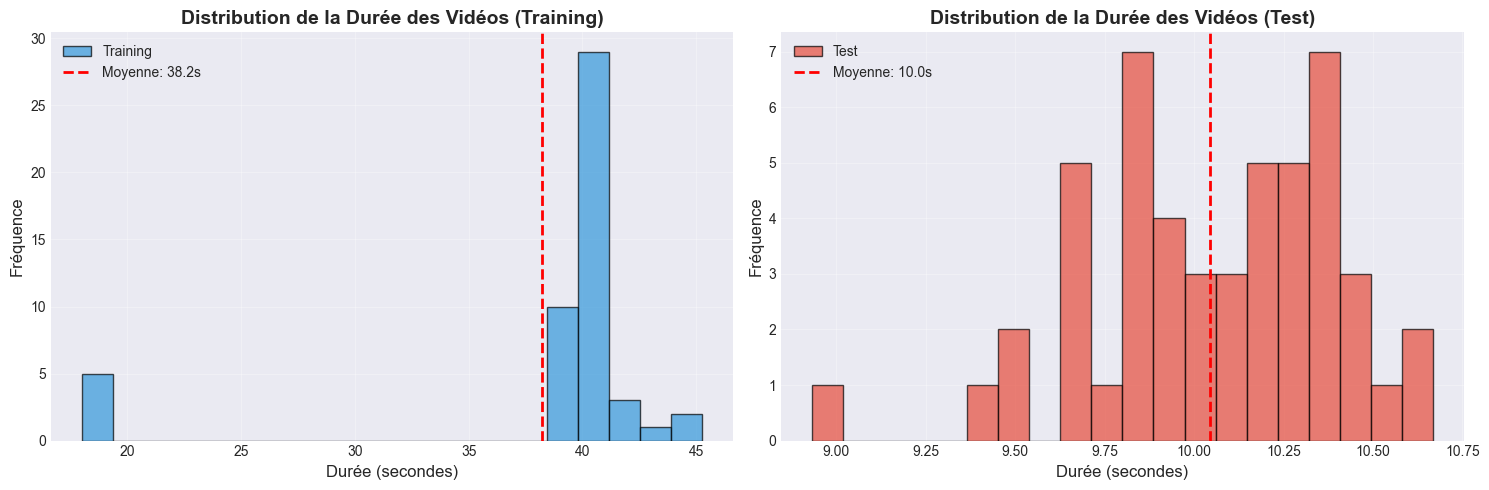


💡 INSIGHT:
   Les vidéos du training set sont ~3.8x plus longues que celles du test set
   Ceci est normal : les vidéos de test sont tronquées avant l'événement (500ms, 1000ms ou 1500ms)


In [26]:
# Visualisation comparative
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set - Distribution de la durée
axes[0].hist(train_props_df['duration'], bins=20, color='#3498db', edgecolor='black', alpha=0.7, label='Training')
axes[0].axvline(train_props_df['duration'].mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {train_props_df["duration"].mean():.1f}s')
axes[0].set_title('Distribution de la Durée des Vidéos (Training)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Durée (secondes)', fontsize=12)
axes[0].set_ylabel('Fréquence', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test set - Distribution de la durée
axes[1].hist(test_props_df['duration'], bins=20, color='#e74c3c', edgecolor='black', alpha=0.7, label='Test')
axes[1].axvline(test_props_df['duration'].mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {test_props_df["duration"].mean():.1f}s')
axes[1].set_title('Distribution de la Durée des Vidéos (Test)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Durée (secondes)', fontsize=12)
axes[1].set_ylabel('Fréquence', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 INSIGHT:")
print(f"   Les vidéos du training set sont ~{train_props_df['duration'].mean() / test_props_df['duration'].mean():.1f}x plus longues que celles du test set")
print(f"   Ceci est normal : les vidéos de test sont tronquées avant l'événement (500ms, 1000ms ou 1500ms)")

### 4.3 Visualisation d'Exemples de Vidéos

In [17]:
def extract_frames(video_path, num_frames=6):
    """Extraire des frames uniformément espacées d'une vidéo"""
    cap = cv2.VideoCapture(str(video_path))
    
    if not cap.isOpened():
        return None
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, frame_count - 1, num_frames, dtype=int)
    
    frames = []
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    
    cap.release()
    return frames

def visualize_video_samples(df, video_dir, target_value, num_videos=3, num_frames=6):
    """Visualiser des échantillons de vidéos"""
    # Filtrer par classe
    samples = df[df['target'] == target_value].sample(n=min(num_videos, len(df[df['target'] == target_value])))
    
    label = "Collision/Near-miss" if target_value == 1 else "Conduite Normale"
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        video_path = video_dir / f"{row['id']}.mp4"
        
        if not video_path.exists():
            print(f"⚠️ Vidéo {row['id']} non trouvée")
            continue
        
        frames = extract_frames(video_path, num_frames)
        
        if frames is None:
            continue
        
        # Affichage
        fig, axes = plt.subplots(1, num_frames, figsize=(20, 4))
        
        title = f"{label} - ID: {row['id']}"
        if target_value == 1:
            title += f" | Event: {row['time_of_event']:.1f}s | Alert: {row['time_of_alert']:.1f}s | TTA: {row['time_of_event'] - row['time_of_alert']:.2f}s"
        
        fig.suptitle(title, fontsize=14, fontweight='bold')
        
        for i, frame in enumerate(frames):
            axes[i].imshow(frame)
            axes[i].axis('off')
            axes[i].set_title(f'Frame {i+1}', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*100 + "\n")

In [13]:
print("🎥 EXEMPLES DE VIDÉOS - CONDUITE NORMALE (Classe 0)\n")
visualize_video_samples(train_df, TRAIN_VIDEO_DIR, target_value=0, num_videos=2, num_frames=6)

🎥 EXEMPLES DE VIDÉOS - CONDUITE NORMALE (Classe 0)

⚠️ Vidéo 1875.0 non trouvée
⚠️ Vidéo 1071.0 non trouvée


In [14]:
print("🎥 EXEMPLES DE VIDÉOS - COLLISION/NEAR-MISS (Classe 1)\n")
visualize_video_samples(train_df, TRAIN_VIDEO_DIR, target_value=1, num_videos=2, num_frames=6)

🎥 EXEMPLES DE VIDÉOS - COLLISION/NEAR-MISS (Classe 1)

⚠️ Vidéo 227.0 non trouvée
⚠️ Vidéo 713.0 non trouvée


## 📝 5. Résumé et Insights

In [15]:
print("="*100)
print("📊 RÉSUMÉ DE L'ANALYSE EXPLORATOIRE")
print("="*100)

print("\n🎯 1. DATASET")
print(f"   • Training: {len(train_df)} vidéos (50% positives, 50% négatives) ✅ ÉQUILIBRÉ")
print(f"   • Test: {len(test_df)} vidéos (labels inconnus)")
print(f"   • Total: {len(train_df) + len(test_df)} vidéos (~31 GB)")

print("\n🎥 2. PROPRIÉTÉS DES VIDÉOS")
print(f"   • Résolution: {train_props_df['width'].mode()[0]}x{train_props_df['height'].mode()[0]} (720p)")
print(f"   • FPS: ~{train_props_df['fps'].mean():.0f} frames/seconde")
print(f"   • Durée Training: ~{train_props_df['duration'].mean():.0f} secondes")
print(f"   • Durée Test: ~{test_props_df['duration'].mean():.0f} secondes")
print(f"   • Frames Training: ~{train_props_df['frame_count'].mean():.0f} frames/vidéo")

print("\n⏱️ 3. TIME-TO-ACCIDENT (TTA)")
print(f"   • Moyenne: {positive_samples['time_to_accident'].mean():.2f} secondes")
print(f"   • Médiane: {positive_samples['time_to_accident'].median():.2f} secondes")
print(f"   • Range: [{positive_samples['time_to_accident'].min():.2f}s - {positive_samples['time_to_accident'].max():.2f}s]")

print("\n💡 4. INSIGHTS CLÉS POUR LA MODÉLISATION")
print("   ✅ Dataset équilibré → Pas besoin de class weighting")
print("   ✅ Vidéos haute qualité (720p, 30fps) → Bonne résolution pour feature extraction")
print("   ⚠️ Vidéos longues (~40s) → Besoin d'échantillonnage temporel intelligent")
print("   ⚠️ Test set court (~10s) → Adapter le pipeline pour inférence rapide")
print("   📊 TTA variable → Le modèle doit être robuste à différents temps d'anticipation")

print("\n🎯 5. CHALLENGES IDENTIFIÉS")
print("   🔸 Extraction de features temporelles efficace (vidéos longues)")
print("   🔸 Anticipation précoce (prédire 0.5-1.5s avant l'événement)")
print("   🔸 Généralisation (diversité des scénarios)")
print("   🔸 Temps d'inférence (important pour application temps réel)")

print("\n🚀 6. RECOMMANDATIONS POUR LA SUITE")
print("   1️⃣ Utiliser un échantillonnage temporel (ex: 16-32 frames/vidéo)")
print("   2️⃣ Augmentation de données (flip, rotation, color jitter, temporal shift)")
print("   3️⃣ Tester plusieurs architectures (2D CNN+LSTM, 3D CNN, Transformers)")
print("   4️⃣ Focus sur le time-to-accident moyen (~{:.1f}s) pour l'entraînement".format(positive_samples['time_to_accident'].mean()))
print("   5️⃣ Évaluation sur validation set avec même distribution que test (vidéos tronquées)")

print("\n" + "="*100)
print("✅ ANALYSE EXPLORATOIRE TERMINÉE - PRÊT POUR LA MODÉLISATION!")
print("="*100)

📊 RÉSUMÉ DE L'ANALYSE EXPLORATOIRE

🎯 1. DATASET
   • Training: 1500 vidéos (50% positives, 50% négatives) ✅ ÉQUILIBRÉ
   • Test: 1344 vidéos (labels inconnus)
   • Total: 2844 vidéos (~31 GB)

🎥 2. PROPRIÉTÉS DES VIDÉOS
   • Résolution: 1280x720 (720p)
   • FPS: ~30 frames/seconde
   • Durée Training: ~38 secondes
   • Durée Test: ~10 secondes
   • Frames Training: ~1135 frames/vidéo

⏱️ 3. TIME-TO-ACCIDENT (TTA)
   • Moyenne: 1.60 secondes
   • Médiane: 1.43 secondes
   • Range: [0.03s - 4.47s]

💡 4. INSIGHTS CLÉS POUR LA MODÉLISATION
   ✅ Dataset équilibré → Pas besoin de class weighting
   ✅ Vidéos haute qualité (720p, 30fps) → Bonne résolution pour feature extraction
   ⚠️ Vidéos longues (~40s) → Besoin d'échantillonnage temporel intelligent
   ⚠️ Test set court (~10s) → Adapter le pipeline pour inférence rapide
   📊 TTA variable → Le modèle doit être robuste à différents temps d'anticipation

🎯 5. CHALLENGES IDENTIFIÉS
   🔸 Extraction de features temporelles efficace (vidéos long

## 📈 6. Export des Statistiques

In [16]:
# Créer un dossier pour les résultats
output_dir = Path('../results')
output_dir.mkdir(exist_ok=True)

# Sauvegarder les statistiques dans un fichier
stats = {
    'dataset': {
        'train_size': len(train_df),
        'test_size': len(test_df),
        'positive_ratio': float(target_counts[1] / len(train_df)),
        'negative_ratio': float(target_counts[0] / len(train_df))
    },
    'video_properties': {
        'train': {
            'avg_duration': float(train_props_df['duration'].mean()),
            'avg_fps': float(train_props_df['fps'].mean()),
            'resolution': f"{int(train_props_df['width'].mode()[0])}x{int(train_props_df['height'].mode()[0])}"
        },
        'test': {
            'avg_duration': float(test_props_df['duration'].mean()),
            'avg_fps': float(test_props_df['fps'].mean()),
            'resolution': f"{int(test_props_df['width'].mode()[0])}x{int(test_props_df['height'].mode()[0])}"
        }
    },
    'time_to_accident': {
        'mean': float(positive_samples['time_to_accident'].mean()),
        'median': float(positive_samples['time_to_accident'].median()),
        'std': float(positive_samples['time_to_accident'].std()),
        'min': float(positive_samples['time_to_accident'].min()),
        'max': float(positive_samples['time_to_accident'].max())
    }
}

import json
with open(output_dir / 'eda_statistics.json', 'w') as f:
    json.dump(stats, f, indent=4)

print("✅ Statistiques sauvegardées dans 'results/eda_statistics.json'")
print("\n💾 Vous pouvez utiliser ces statistiques pour votre mémoire!")

✅ Statistiques sauvegardées dans 'results/eda_statistics.json'

💾 Vous pouvez utiliser ces statistiques pour votre mémoire!


---

## 🎉 Fin de l'Analyse Exploratoire

**Prochaines étapes** :
1. Créer le Dataset PyTorch (`src/data/dataset.py`)
2. Implémenter le modèle baseline (ResNet + LSTM)
3. Pipeline d'entraînement
4. Évaluation et soumission

**Bon courage pour votre mémoire ! 🚀**